<a href="https://colab.research.google.com/github/AyokanmiAremu/QSAR-STUDY/blob/main/WORKSHOP_GBR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
import io
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# sklearn models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

# sklearn tools
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# Statistical packages
import statsmodels.api as sm
from statsmodels.formula.api import ols   # ordinary least squares model
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/NEW_RESEARCH/PSO_MOE_DATA.csv')
df

,Name,Y,X1,X2,X3
0,2h,6.64,0.645439,1.407870,1.360133
1,2g,5.88,-1.068238,1.407870,1.371955
2,2f,5.99,-1.086740,1.407870,1.135888
3,2d,5.44,-1.220433,1.407870,1.281067
4,2c,6.28,1.186341,1.407870,1.345155
5,2b,5.67,0.701469,-0.758084,-0.648081
6,2a,5.50,-0.788827,-0.758084,-1.380526
7,1j,5.85,0.024441,-0.758084,-1.026989
8,1i,6.26,0.818264,-0.758084,-0.053134
9,1h,5.83,1.319969,-0.758084,-0.099229


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score

# Assuming you have already loaded your data as df
# Define X and y from your dataframe (adjust according to your dataframe structure)
X = df.iloc[:, 2:]  # Assuming your features start from the third column
y = df.iloc[:, 1]   # Assuming the target variable is in the second column

# Splitting train and test indices (you can adjust these indices accordingly)
test_indices = [16, 17, 18, 19]
train_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

#test_indices = list(range(16, 20))
#train_indices = list(range(16))


X_train = X.iloc[train_indices]
y_train = y.iloc[train_indices]
X_test = X.iloc[test_indices]
y_test = y.iloc[test_indices]

Tuning Parameters and Building Model

In [ ]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [ ]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Define the objective function for Optuna to optimize
def objective(trial):
    # Suggest hyperparameters using Optuna's trial object
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 1, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.05)

    # Create the GradientBoostingRegressor model
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        learning_rate=learning_rate,
        loss="squared_error"
    )

    # Train the model on the training set
    model.fit(X_train, y_train)

    # Predict on both the training set and test set
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate RMSE for both the training set and test set
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

    # Return the average of the training and test RMSE
    combined_rmse = (rmse_train + rmse_test) / 2

    return combined_rmse  # Return combined RMSE as the objective to minimize

# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Perform optimization
study.optimize(objective, n_trials=20)

# Get the best hyperparameters from the study
best_params = study.best_params
print("Best Hyperparameters (Optuna):", best_params)

# Build the final model with the best hyperparameters
best_model = GradientBoostingRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    learning_rate=best_params['learning_rate'],
    loss="squared_error"
)

# Train the final model on the full training data
best_model.fit(X_train, y_train)

# Evaluate the final model on both the training and test sets
y_pred_train_final = best_model.predict(X_train)
y_pred_test_final = best_model.predict(X_test)

# Calculate RMSE for the final model on both sets
final_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train_final))
final_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test_final))

print(f"Final RMSE on the Training Set: {final_train_rmse}")
print(f"Final RMSE on the Test Set: {final_test_rmse}")


[I 2024-11-06 10:36:41,205] A new study created in memory with name: no-name-432a94d2-7a25-49af-bde2-954e1cf72e32
[I 2024-11-06 10:36:42,628] Trial 0 finished with value: 0.1610791300631593 and parameters: {'n_estimators': 239, 'max_depth': 2, 'min_samples_split': 15, 'learning_rate': 0.048510759380778194}. Best is trial 0 with value: 0.1610791300631593.
[I 2024-11-06 10:36:43,555] Trial 1 finished with value: 0.24787431125692735 and parameters: {'n_estimators': 238, 'max_depth': 5, 'min_samples_split': 3, 'learning_rate': 0.020908427985061075}. Best is trial 0 with value: 0.1610791300631593.
[I 2024-11-06 10:36:44,176] Trial 2 finished with value: 0.22144904173665095 and parameters: {'n_estimators': 236, 'max_depth': 10, 'min_samples_split': 4, 'learning_rate': 0.047223724146270386}. Best is trial 0 with value: 0.1610791300631593.
[I 2024-11-06 10:36:45,068] Trial 3 finished with value: 0.5917716553236809 and parameters: {'n_estimators': 194, 'max_depth': 2, 'min_samples_split': 17, '

Best Hyperparameters (Optuna): {'n_estimators': 291, 'max_depth': 3, 'min_samples_split': 12, 'learning_rate': 0.03569285569360422}
Final RMSE on the Training Set: 0.059355217638358444
Final RMSE on the Test Set: 0.16820982673585594


In [ ]:
# Instantiate the Gradient Boosting Regressor with the best hyperparameters
best_model = GradientBoostingRegressor(**best_params)

# Fit the model on the training data
best_model.fit(X_train, y_train)

# Predict on the training data
y_pred_train = best_model.predict(X_train)


In [ ]:
from sklearn.metrics import r2_score, mean_squared_error

# Predict on the test data
y_pred_test = best_model.predict(X_test)

# Evaluate the model performance for training data
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
r2_train = r2_score(y_train, y_pred_train)

# Evaluate the model performance for testing data
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
r2_test = r2_score(y_test, y_pred_test)

# Print out the results
print('RMSE (train): %.3f' % rmse_train)
print('R² (train): %.3f' % r2_train)
print('RMSE (test): %.3f' % rmse_test)
print('R² (test): %.3f' % r2_test)


RMSE (train): 0.059
R² (train): 0.990
RMSE (test): 0.170
R² (test): 0.913


In [ ]:
import pandas as pd

# Creating DataFrame for training set results
train_results = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_train, 'Error': y_train - y_pred_train})
print("Train Set Results:")
print(train_results)

# Saving the training set results as a CSV file
train_results.to_csv('/content/drive/MyDrive/NEW_RESEARCH/NEW_predVSexp_train.csv', index=False)


# Creating DataFrame for test set results
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test, 'Error': y_test - y_pred_test})
print("Test Set Results:")
print(test_results)

# Saving the test set results as a CSV file
test_results.to_csv('/content/drive/MyDrive/NEW_RESEARCH/NEW_predVSexp_test.csv', index=False)

print("Results have been saved as 'train_results.csv' and 'test_results.csv'.")


Train Set Results:
    Actual  Predicted     Error
0     6.64   6.573779  0.066221
1     5.88   5.917466 -0.037466
2     5.99   5.904387  0.085613
3     5.44   5.507673 -0.067673
4     6.28   6.286411 -0.006410
5     5.67   5.757612 -0.087612
6     5.50   5.484836  0.015164
7     5.85   5.841286  0.008714
8     6.26   6.122099  0.137901
9     5.83   5.864987 -0.034987
10    5.35   5.348794  0.001206
11    5.33   5.387241 -0.057241
12    7.64   7.607003  0.032997
13    5.07   5.104034 -0.034034
14    6.42   6.479317 -0.059317
15    6.07   6.033076  0.036924
Test Set Results:
    Actual  Predicted     Error
16    6.89   6.569837  0.320163
17    6.07   5.960103  0.109897
18    5.34   5.344417 -0.004417
19    5.69   5.663905  0.026095
Results have been saved as 'train_results.csv' and 'test_results.csv'.


In [ ]:
_# Creating DataFrame for training set results
train_results = pd.DataFrame({'Actual': y_train, 'Predicted': y_pred_train, 'Error': y_train - y_pred_train})
print("Train Set Results:")
print(train_results)

# Creating DataFrame for test set results
test_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_test, 'Error': y_test - y_pred_test})
print("Test Set Results:")
print(test_results)


Train Set Results:
    Actual  Predicted     Error
0     6.64   6.573779  0.066221
1     5.88   5.917466 -0.037466
2     5.99   5.904387  0.085613
3     5.44   5.507673 -0.067673
4     6.28   6.286411 -0.006410
5     5.67   5.757612 -0.087612
6     5.50   5.484836  0.015164
7     5.85   5.841286  0.008714
8     6.26   6.122099  0.137901
9     5.83   5.864987 -0.034987
10    5.35   5.348794  0.001206
11    5.33   5.387241 -0.057241
12    7.64   7.607003  0.032997
13    5.07   5.104034 -0.034034
14    6.42   6.479317 -0.059317
15    6.07   6.033076  0.036924
Test Set Results:
    Actual  Predicted     Error
16    6.89   6.569837  0.320163
17    6.07   5.960103  0.109897
18    5.34   5.344417 -0.004417
19    5.69   5.663905  0.026095


In [ ]:
from sklearn.model_selection import cross_val_predict

# Perform cross-validation predictions
y_cv_pred = cross_val_predict(best_model, X_train, y_train, cv=5)

# Calculate Q^2 statistic
q2 = r2_score(y_train, y_cv_pred)
print(f'Q^2: {q2:.3f}')


NameError: name 'best_model' is not defined

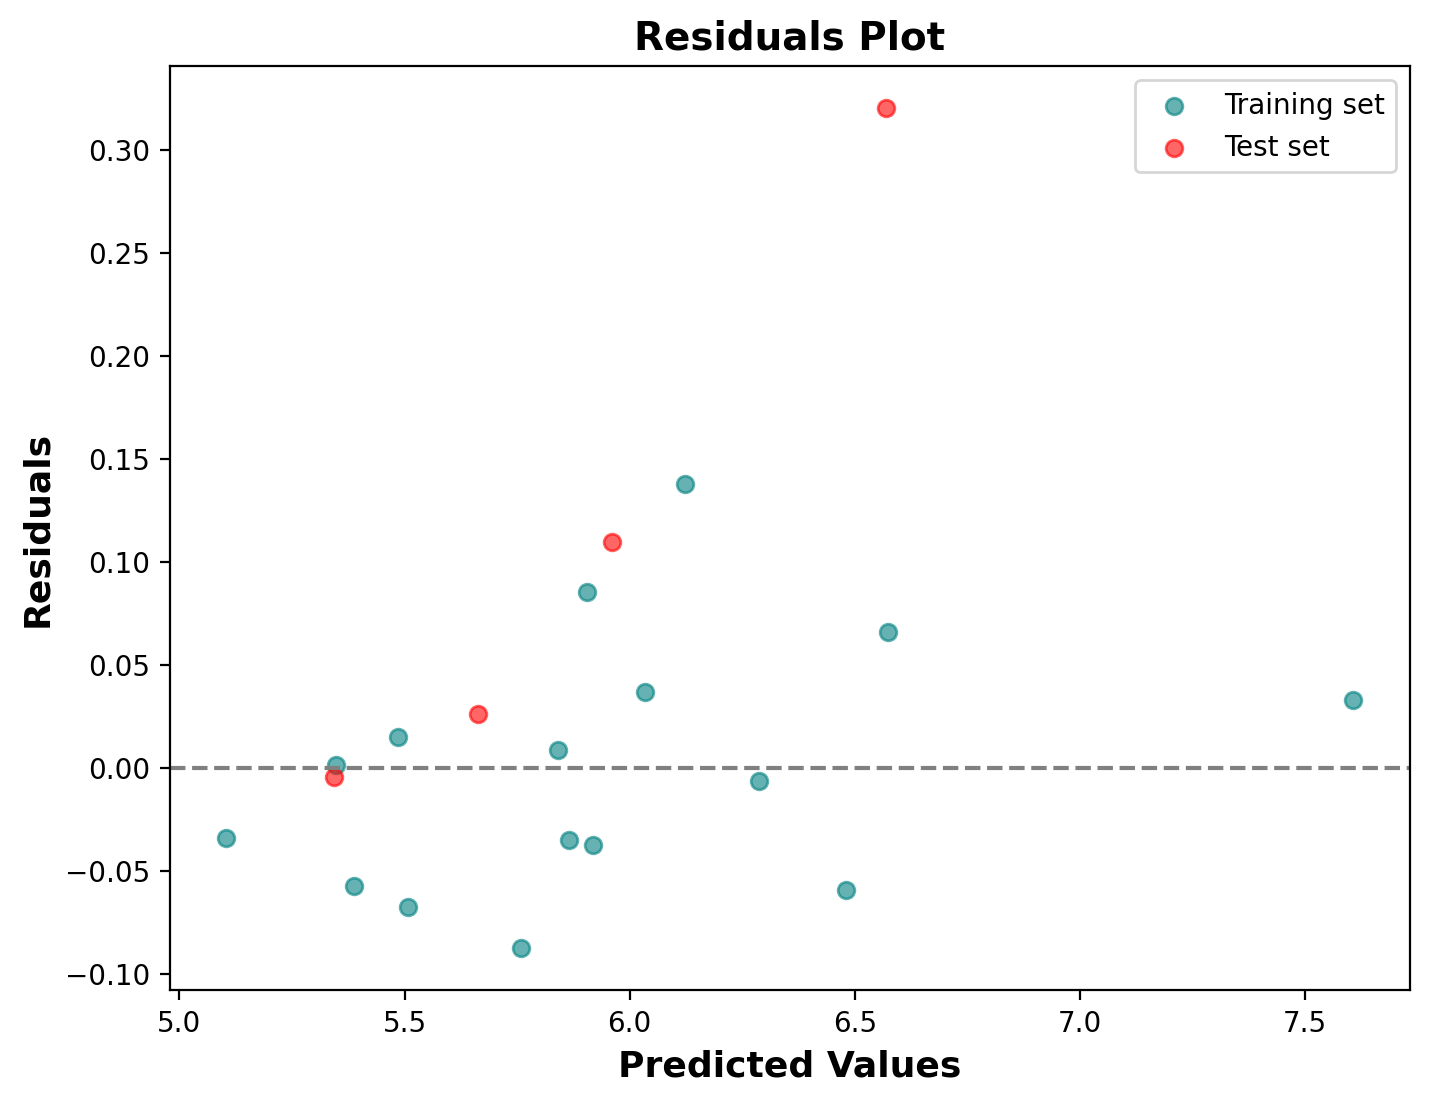

In [ ]:
# Calculate residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# Plot residuals for training and test sets
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, residuals_train, color='teal', label='Training set', alpha=0.6)
plt.scatter(y_pred_test, residuals_test, color='red', label='Test set', alpha=0.6)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Predicted Values', fontsize=13, fontweight='bold')
plt.ylabel('Residuals', fontsize=13, fontweight='bold')
plt.title('Residuals Plot', fontsize=14, fontweight='bold')
plt.legend()
plt.show()


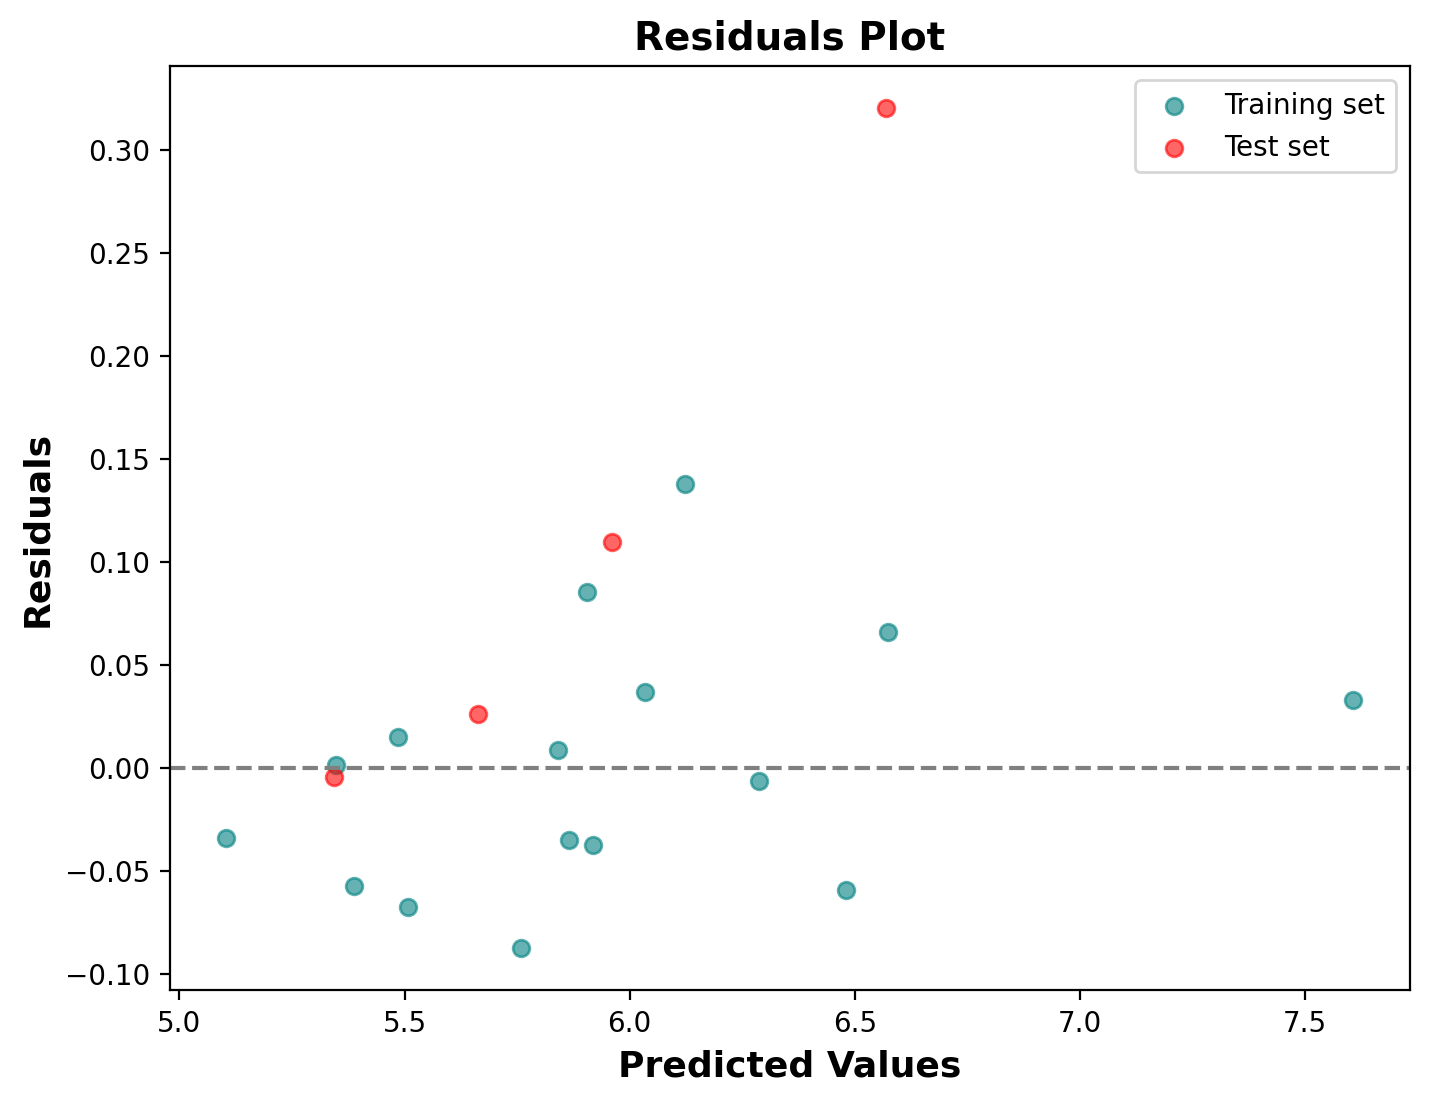

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# Ensure that both the training and test residuals arrays are of the same length when combined
# Combine both train and test results into a single DataFrame for saving
residuals_combined_df = pd.DataFrame({
    'Predicted': pd.concat([pd.Series(y_pred_train), pd.Series(y_pred_test)], ignore_index=True),
    'Residuals': pd.concat([pd.Series(residuals_train), pd.Series(residuals_test)], ignore_index=True)
})

# Save the DataFrame to a CSV file
residuals_combined_df.to_csv('/content/drive/MyDrive/NEW_RESEARCH/NEW_GBR_RESIDUAL.csv', index=False)

# Plot residuals for training and test sets
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_train, residuals_train, color='teal', label='Training set', alpha=0.6)
plt.scatter(y_pred_test, residuals_test, color='red', label='Test set', alpha=0.6)
plt.axhline(y=0, color='gray', linestyle='--')
plt.xlabel('Predicted Values', fontsize=13, fontweight='bold')
plt.ylabel('Residuals', fontsize=13, fontweight='bold')
plt.title('Residuals Plot', fontsize=14, fontweight='bold')
plt.legend()
plt.show()


Randomization

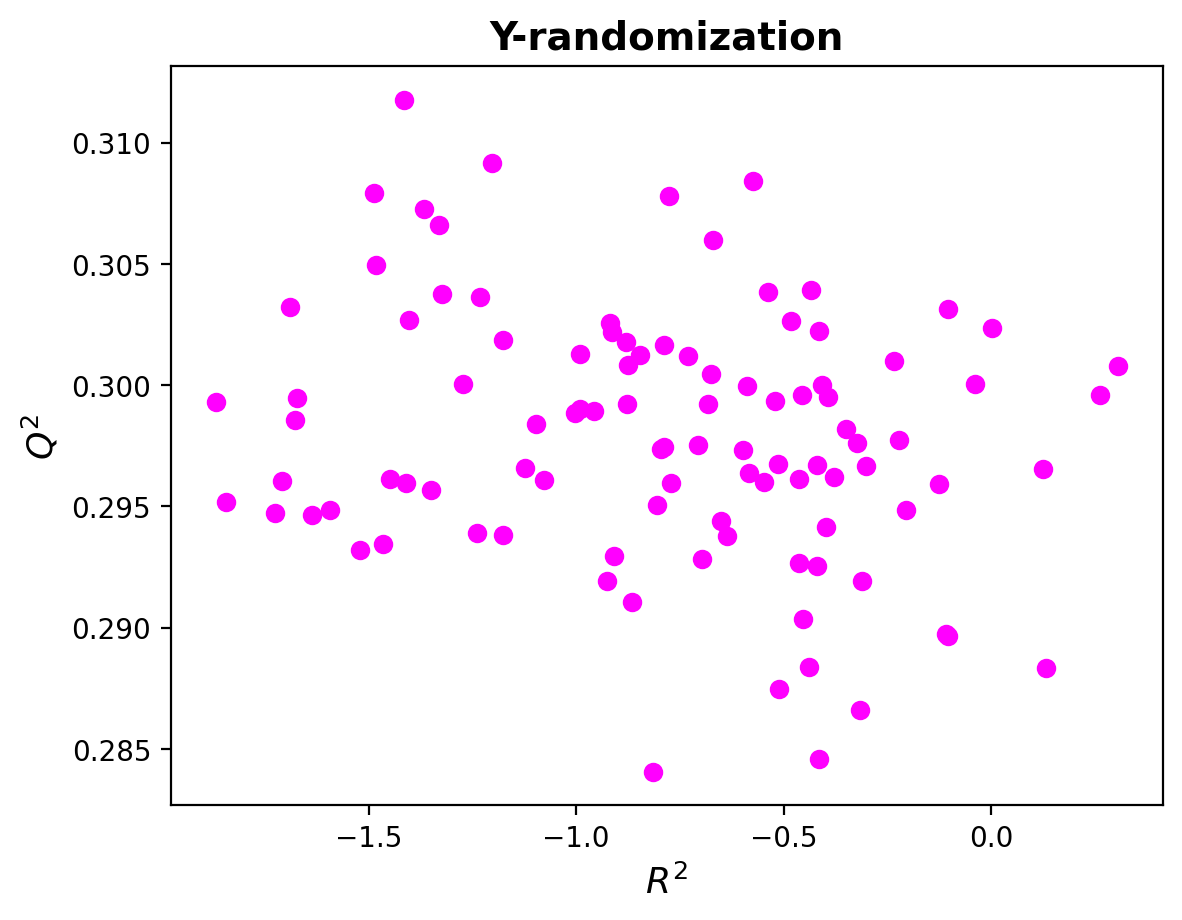

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.utils import shuffle

# Best hyperparameters obtained from Optuna optimization
best_params = {
    'n_estimators': 291,  # Replace with your optimized value
    'max_depth': 3,        # Replace with your optimized value
    'min_samples_split': 12,  # Replace with your optimized value
    'learning_rate': 0.03569285569360422   # Replace with your optimized value
}

# Y-randomization
n_iterations = 100
r2_scores = []
q2_scores = []

for i in range(n_iterations):
    # Shuffle the target variable (y_train)
    y_random = shuffle(y_train, random_state=i)

    # Train the model with the shuffled target variable
    model_random = GradientBoostingRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        learning_rate=best_params['learning_rate'],
        loss="squared_error"
    ).fit(X_train, y_random)

    # Predict on the training data
    y_pred_random = model_random.predict(X_train)

    # Calculate R^2 for the random model on training data
    r2_random = r2_score(y_train, y_pred_random)

    # Perform cross-validated predictions and calculate Q^2
    y_cv_pred = cross_val_predict(model_random, X_train, y_train, cv=5)
    q2_random = r2_score(y_train, y_cv_pred)

    # Append the scores
    r2_scores.append(r2_random)
    q2_scores.append(q2_random)

# Plotting Y-randomization
plt.scatter(r2_scores, q2_scores, color='magenta')
plt.xlabel('$R^2$', fontsize=13, fontweight='bold')
plt.ylabel('$Q^2$', fontsize=13, fontweight='bold')
plt.title('Y-randomization', fontsize=14, fontweight='bold')
plt.show()


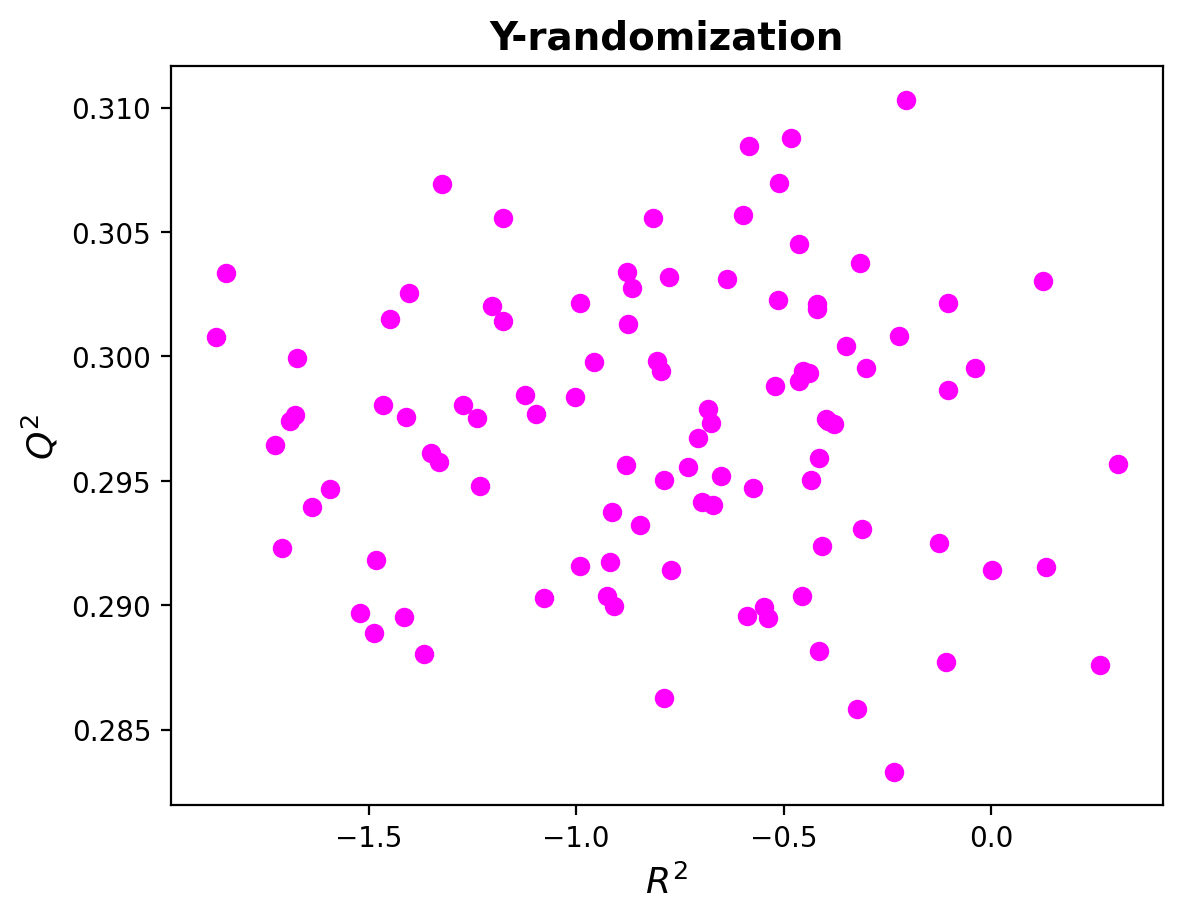

Y-randomization results have been saved as 'y_randomization_results.csv'.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.utils import shuffle

# Best hyperparameters obtained from Optuna optimization
best_params = {
    'n_estimators': 291,  # Replace with your optimized value
    'max_depth': 3,        # Replace with your optimized value
    'min_samples_split': 12,  # Replace with your optimized value
    'learning_rate': 0.03569285569360422   # Replace with your optimized value
}

# Y-randomization
n_iterations = 100
r2_scores = []
q2_scores = []

for i in range(n_iterations):
    # Shuffle the target variable (y_train)
    y_random = shuffle(y_train, random_state=i)

    # Train the model with the shuffled target variable
    model_random = GradientBoostingRegressor(
        n_estimators=best_params['n_estimators'],
        max_depth=best_params['max_depth'],
        min_samples_split=best_params['min_samples_split'],
        learning_rate=best_params['learning_rate'],
        loss="squared_error"
    ).fit(X_train, y_random)

    # Predict on the training data
    y_pred_random = model_random.predict(X_train)

    # Calculate R^2 for the random model on training data
    r2_random = r2_score(y_train, y_pred_random)

    # Perform cross-validated predictions and calculate Q^2
    y_cv_pred = cross_val_predict(model_random, X_train, y_train, cv=5)
    q2_random = r2_score(y_train, y_cv_pred)

    # Append the scores
    r2_scores.append(r2_random)
    q2_scores.append(q2_random)

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'R^2_Score': r2_scores,
    'Q^2_Score': q2_scores
})

# Save the results to a CSV file in your directory
results_df.to_csv('/content/drive/MyDrive/NEW_RESEARCH/NEW_GBR_randomization.csv', index=False)

# Plotting Y-randomization
plt.scatter(r2_scores, q2_scores, color='magenta')
plt.xlabel('$R^2$', fontsize=13, fontweight='bold')
plt.ylabel('$Q^2$', fontsize=13, fontweight='bold')
plt.title('Y-randomization', fontsize=14, fontweight='bold')
plt.show()

print("Y-randomization results have been saved as 'y_randomization_results.csv'.")


Williams plot

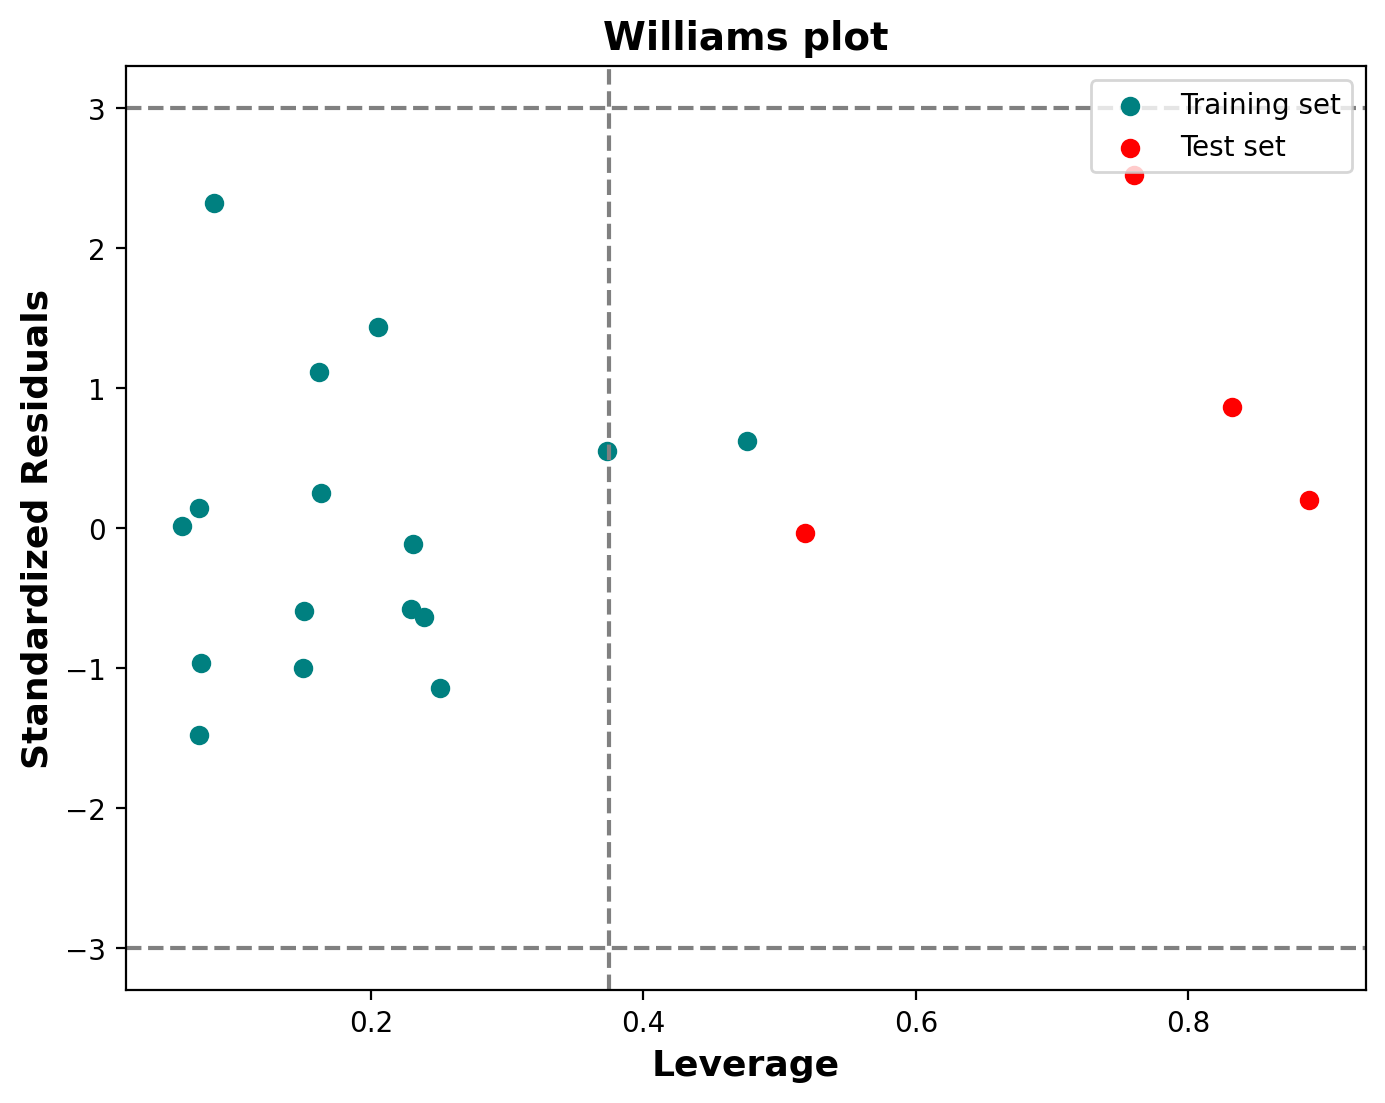

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import pandas as pd

# Calculate leverage values using the Moore-Penrose pseudo-inverse
def calculate_leverage(X):
    X = np.array(X)
    hat_matrix = X.dot(np.linalg.pinv(X.T.dot(X))).dot(X.T)
    return np.diag(hat_matrix)

# Leverage values for training and testing sets
leverage_train = calculate_leverage(X_train)
leverage_test = calculate_leverage(X_test)

# Calculate standardized residuals
def calculate_standardized_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    std_residuals = residuals / np.std(residuals)
    return std_residuals

# Predictions using the best model
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Standardized residuals for training and testing sets
std_residuals_train = calculate_standardized_residuals(y_train, y_pred_train)
std_residuals_test = calculate_standardized_residuals(y_test, y_pred_test)

# Plotting Williams plot
plt.figure(figsize=(8, 6))
plt.scatter(leverage_train, std_residuals_train, color='teal', label='Training set')
plt.scatter(leverage_test, std_residuals_test, color='red', label='Test set')
plt.axhline(y=3, color='gray', linestyle='--')
plt.axhline(y=-3, color='gray', linestyle='--')
plt.axvline(x=2 * np.mean(leverage_train), color='gray', linestyle='--')
plt.xlabel('Leverage', fontsize=13, fontweight='bold')
plt.ylabel('Standardized Residuals', fontsize=13, fontweight='bold')
plt.title('Williams plot', fontsize=14, fontweight='bold')
plt.legend(loc='upper right')
plt.show()


PI

SKIPP

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Assuming train and test datasets are already loaded as pandas DataFrames
y_train = train.iloc[:, 1]
X_train = train.iloc[:, 2:]

y_test = test.iloc[:, 1]
X_test = test.iloc[:, 2:]

# New set of compounds and their features
data = {
    "Structures": ["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9", "D10", "R2"],
    "Electron C2": [0.313, 0.308, 0.329, 0.33, 0.33, 0.32, 0.324, 0.314, 0.32, 0.321, 0.354],
    "Electron N": [-0.705, -0.704, -0.706, -0.717, -0.712, -0.712, -0.712, -0.705, -0.711, -0.712, -0.696],
    "Molecular Weight": [199, 212, 256, 284, 315, 347, 255, 229, 437, 257, 212]
}

new_compounds = pd.DataFrame(data)

# Ensure the new DataFrame has the same columns as the training data
X_new = pd.DataFrame(columns=X_train.columns)
for column in X_new.columns:
    if column in new_compounds.columns:
        X_new[column] = new_compounds[column]
    else:
        X_new[column] = 0  # Fill missing columns with 0

# Fill any remaining NaN values with 0
X_new = X_new.fillna(0)

# Predicting the LogKow for the new compounds
y_pred_new = model.predict(X_new)

# Adding the predictions to the new_compounds DataFrame
new_compounds["Predicted LogKow"] = y_pred_new

print(new_compounds)


   Structures  Electron C2  Electron N  Molecular Weight  Predicted LogKow
0          D1        0.313      -0.705               199          5.186289
1          D2        0.308      -0.704               212          5.186289
2          D3        0.329      -0.706               256          7.283688
3          D4        0.330      -0.717               284          8.435913
4          D5        0.330      -0.712               315          9.637395
5          D6        0.320      -0.712               347          8.695428
6          D7        0.324      -0.712               255          7.101940
7          D8        0.314      -0.705               229          5.186289
8          D9        0.320      -0.711               437          9.788576
9         D10        0.321      -0.712               257          7.101940
10         R2        0.354      -0.696               212          6.430080


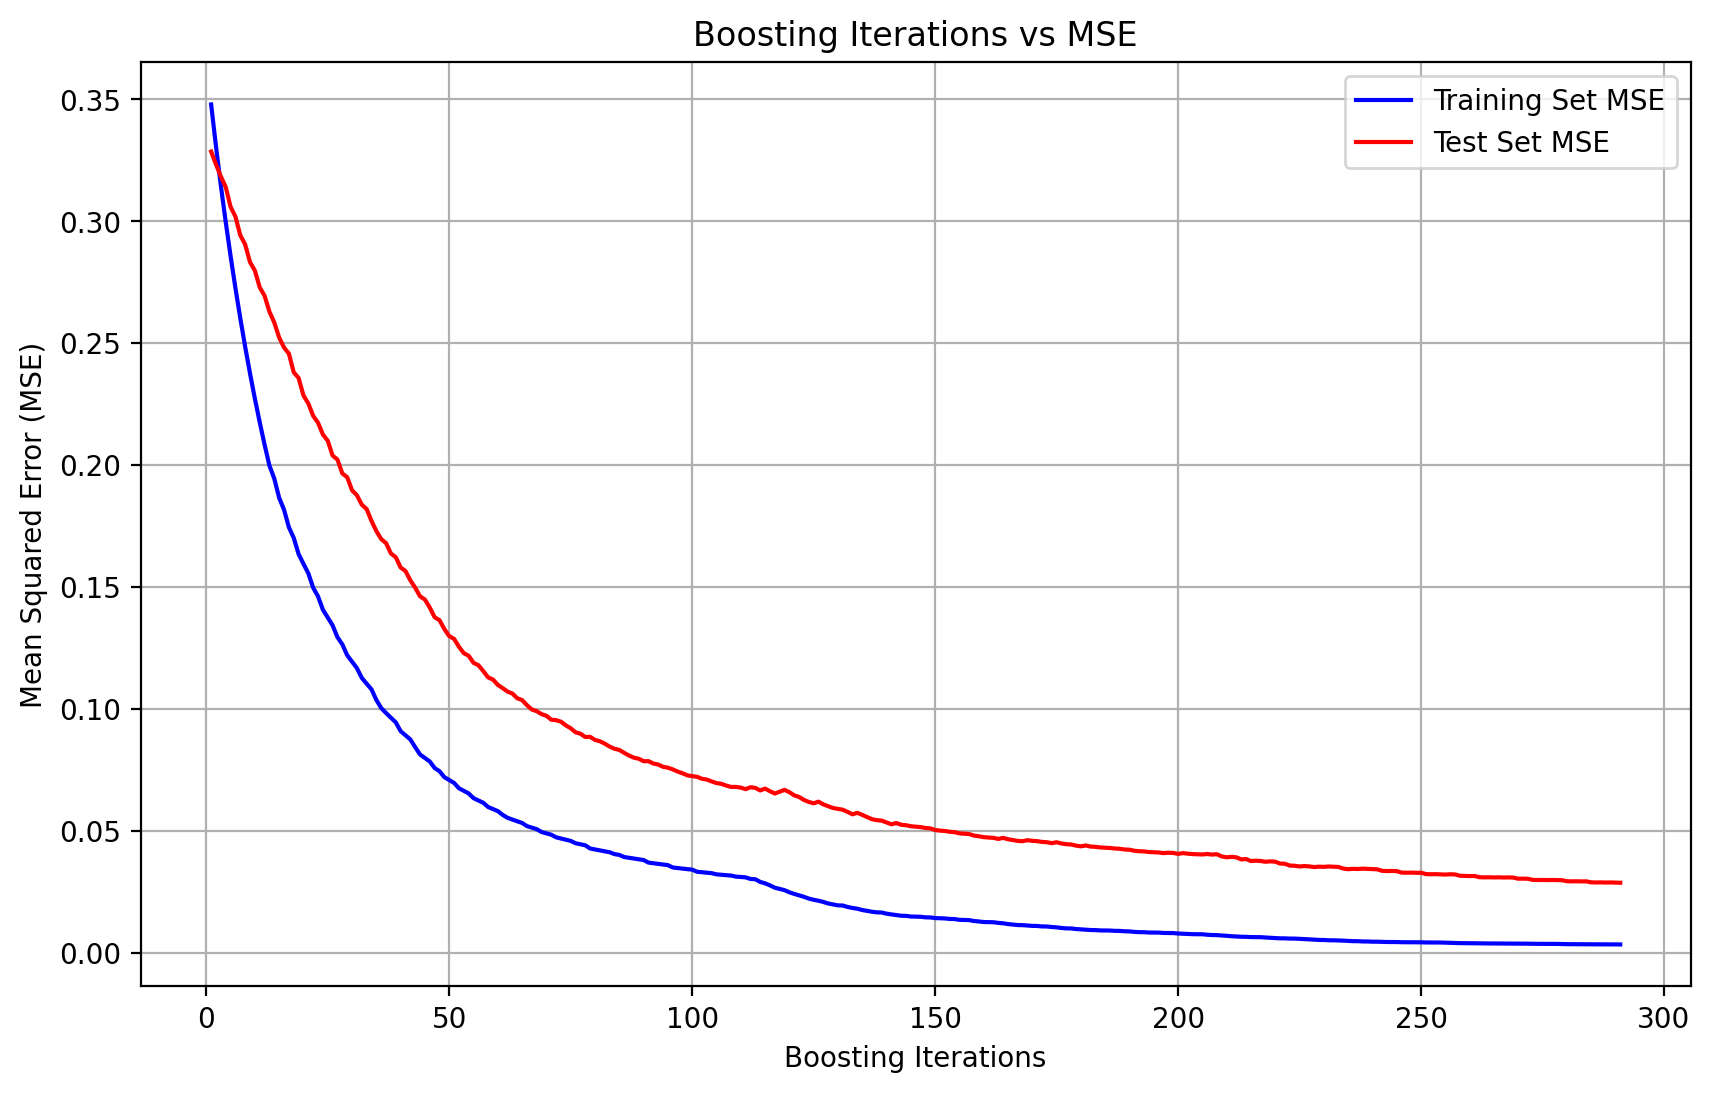

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming best_params and best_model are already defined
test_score = np.zeros((best_params["n_estimators"],), dtype=np.float64)

# Using the best_model to compute test set scores for each boosting iteration
for i, y_pred in enumerate(best_model.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(np.arange(best_params["n_estimators"]) + 1, best_model.train_score_, 'b-', label='Training Set MSE')
plt.plot(np.arange(best_params["n_estimators"]) + 1, test_score, 'r-', label='Test Set MSE')
plt.title('Boosting Iterations vs MSE')
plt.xlabel('Boosting Iterations')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Assuming best_params and best_model are already defined
test_score = np.zeros((best_params["n_estimators"],), dtype=np.float64)

# Using the best_model instead of GBR
for i, y_pred in enumerate(best_model.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

# Print the boosting iterations, training set scores, and test set scores
print("Boosting Iterations, Training Set Score, Test Set Score")
for i in range(best_params["n_estimators"]):
    print(f"{i+1}, {best_model.train_score_[i]}, {test_score[i]}")


Boosting Iterations, Training Set Score, Test Set Score
1, 0.347912835706618, 0.32860142885300436
2, 0.33067681628529233, 0.32330524477623324
3, 0.31464924402872346, 0.3183900393917775
4, 0.29974077336434324, 0.31404463188789805
5, 0.28579033525321607, 0.30594944067388885
6, 0.272605793670172, 0.30192119894651814
7, 0.26026378979824727, 0.29425702078364074
8, 0.24858907143698222, 0.290520072452527
9, 0.23765607906087935, 0.28325826233659834
10, 0.22730479720521501, 0.2797891849625299
11, 0.2176071891352493, 0.2729035303103344
12, 0.20841678596546717, 0.26945597526681786
13, 0.19983130330283458, 0.26294961069237316
14, 0.1944850421741024, 0.25848145492648067
15, 0.18662530997976287, 0.25233430463271855
16, 0.18177198219399338, 0.2482588966153006
17, 0.17457339914166178, 0.24574849566055548
18, 0.17020322453155068, 0.2380937055541462
19, 0.16357282846113264, 0.23576279627508165
20, 0.15956965922804967, 0.22858521867800133
21, 0.15569697382797346, 0.22532670215318631
22, 0.149772758876627

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Assuming best_params and best_model are already defined
test_score = np.zeros((best_params["n_estimators"],), dtype=np.float64)

# Using the best_model instead of GBR
for i, y_pred in enumerate(best_model.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

# Prepare data for saving
data = {
    "Boosting Iterations": np.arange(1, best_params["n_estimators"] + 1),
    "Training Set Score": best_model.train_score_,
    "Test Set Score": test_score
}

# Create a DataFrame
output_df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
output_df.to_csv('/content/drive/MyDrive/NEW_RESEARCH/NEW_GBRLOSS_OUT.csv', index=False)

print("Output saved to /content/drive/MyDrive/NEW_RESEARCH/NEW_GBRLOSS_OUT.csv")


Output saved to /content/drive/MyDrive/NEW_RESEARCH/NEW_GBRLOSS_OUT.csv


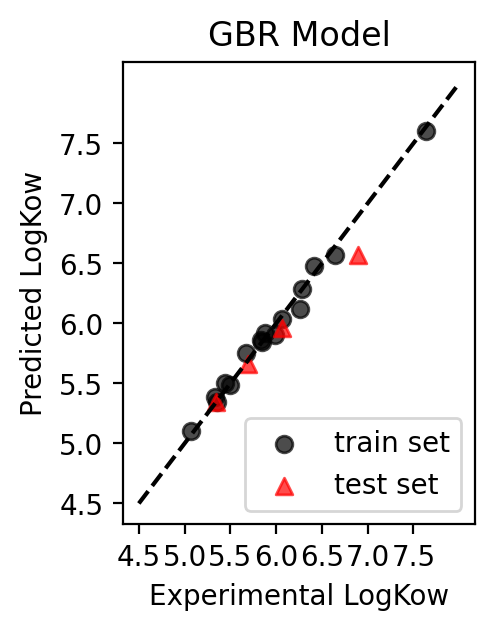

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data visualization
plt.figure(figsize=(5, 3))

# 1 row, 2 column, plot 1
plt.subplot(1, 2, 1)

plt.scatter(x=y_train, y=y_pred_train, c="black", alpha=0.7)
plt.scatter(x=y_test, y=y_pred_test, c="r", marker='^', alpha=0.7)

plt.legend(("train set", "test set"), loc="lower right")
plt.plot([4.5, 8], [4.5, 8], "--", color="black")

x_ticks = np.arange(4.5, 8, 0.5)
y_ticks = np.arange(4.5, 8, 0.5)

plt.xticks(x_ticks)
plt.yticks(y_ticks)

plt.title('GBR Model')
plt.ylabel('Predicted LogKow')
plt.xlabel('Experimental LogKow')

plt.show()


In [ ]:
!pip install shap

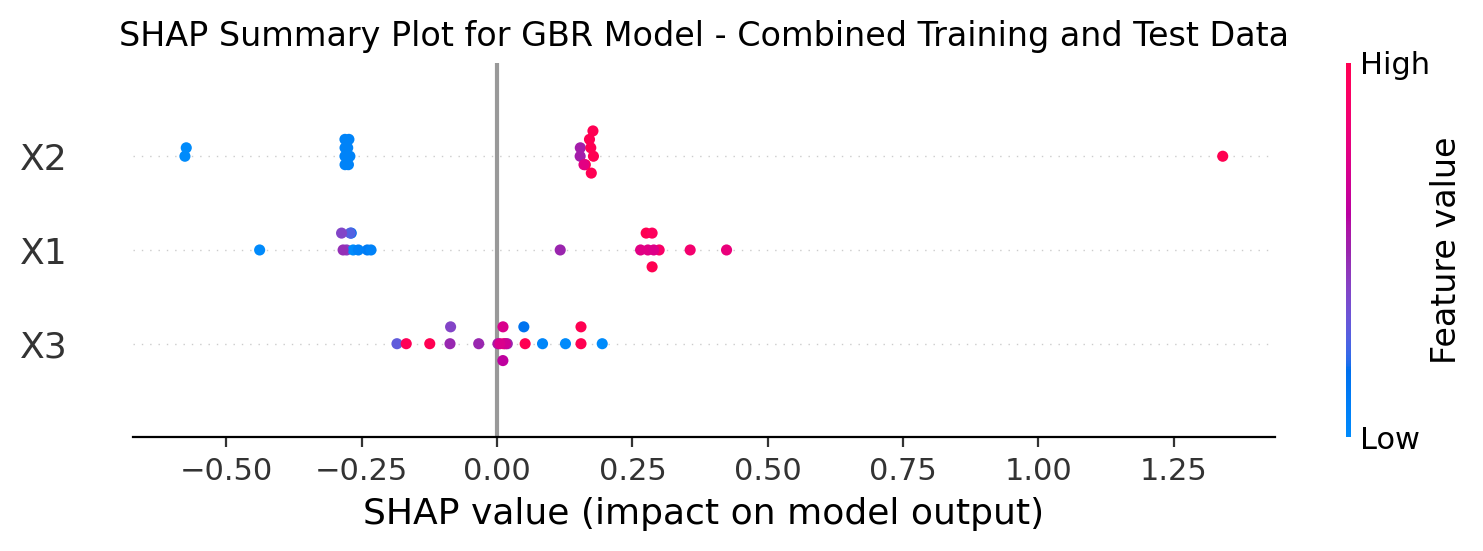

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


# SHAP Analysis
explainer = shap.Explainer(best_model, X_train)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Create Pandas DataFrames with feature names for X_train and X_test
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate SHAP values and data
shap_values_combined = np.concatenate((shap_values_train.values, shap_values_test.values), axis=0)
X_combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Summary plot of combined SHAP values with feature names
shap.summary_plot(shap_values_combined, X_combined_df, show=False)
plt.title("SHAP Summary Plot for GBR Model - Combined Training and Test Data")
plt.show()

In [ ]:
import shap
import pandas as pd
import numpy as np

# Assume model, X_train, and X_test are already defined

# SHAP Analysis
explainer = shap.Explainer(best_model, X_train)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Create Pandas DataFrames with feature names for X_train and X_test
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate SHAP values and data
shap_values_combined = np.concatenate((shap_values_train.values, shap_values_test.values), axis=0)
X_combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Calculate mean absolute SHAP values to identify top 3 features
mean_abs_shap_values = np.mean(np.abs(shap_values_combined), axis=0)
top_3_indices = np.argsort(mean_abs_shap_values)[-4:]
top_3_features = X_combined_df.columns[top_3_indices]

# Print SHAP values and corresponding feature values for top 3 features
for i, feature in enumerate(top_3_features):
    print(f"\nFeature: {feature}")
    print("SHAP Value, Feature Value")
    for shap_val, feature_val in zip(shap_values_combined[:, top_3_indices[i]], X_combined_df[feature]):
        print(f"{shap_val}, {feature_val}")



Feature: X3
SHAP Value, Feature Value
0.15503059609909542, 1.36013305
0.051827447488904, 1.37195476
0.012042130452755373, 1.13588818
-0.16785800545767415, 1.28106706
-0.12440642365982058, 1.34515524
-0.184981849626638, -0.64808097
0.0839627113637107, -1.38052599
0.04942625435433001, -1.02698895
0.018867779137508478, -0.05313376
-0.08702007984538795, -0.09922871
-0.03397537634373293, -0.09295966
0.0014991052958066575, 0.07747118
0.015456438697583508, 0.44572307
0.005147520212631207, 0.5522655
0.010712424082157668, 0.25977663
0.1942693277487706, -1.51097542
0.15503059609909542, 1.3546732
0.12638474582126946, -1.48198561
-0.08590431930497289, -0.35091785
0.010902423840889242, 0.55964656

Feature: X1
SHAP Value, Feature Value
0.2894548571057385, 0.64543868
-0.2563306848460343, -1.06823776
-0.2329685682998388, -1.08673998
-0.438752784015378, -1.22043342
0.28643481438120943, 1.18634064
0.2651329352702305, 0.70146869
-0.2694598977723217, -0.78882689
0.11664137138359365, 0.02444121
0.42398108

In [ ]:
import shap
import pandas as pd
import numpy as np

# Assume model, X_train, and X_test are already defined

# SHAP Analysis
explainer = shap.Explainer(best_model, X_train)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Create Pandas DataFrames with feature names for X_train and X_test
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate SHAP values and data
shap_values_combined = np.concatenate((shap_values_train.values, shap_values_test.values), axis=0)
X_combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Calculate mean absolute SHAP values to identify top 3 features
mean_abs_shap_values = np.mean(np.abs(shap_values_combined), axis=0)
top_3_indices = np.argsort(mean_abs_shap_values)[-3:]
top_3_features = X_combined_df.columns[top_3_indices]

# Create a DataFrame to store SHAP values and feature values for top 3 features
output_df = pd.DataFrame()

for i, feature in enumerate(top_3_features):
    output_df[f"{feature}_SHAP"] = shap_values_combined[:, top_3_indices[i]]
    output_df[f"{feature}_Value"] = X_combined_df[feature].values

# Specify the path to save the CSV file
output_path = '/content/drive/MyDrive/NEW_RESEARCH/NEW_GBR_shap_values_top3_features.csv'

# Save the DataFrame to the specified CSV file
output_df.to_csv(output_path, index=False)

print(f"CSV file saved as '{output_path}'")


CSV file saved as '/content/drive/MyDrive/NEW_RESEARCH/NEW_GBR_shap_values_top3_features.csv'


<Figure size 1600x1600 with 0 Axes>

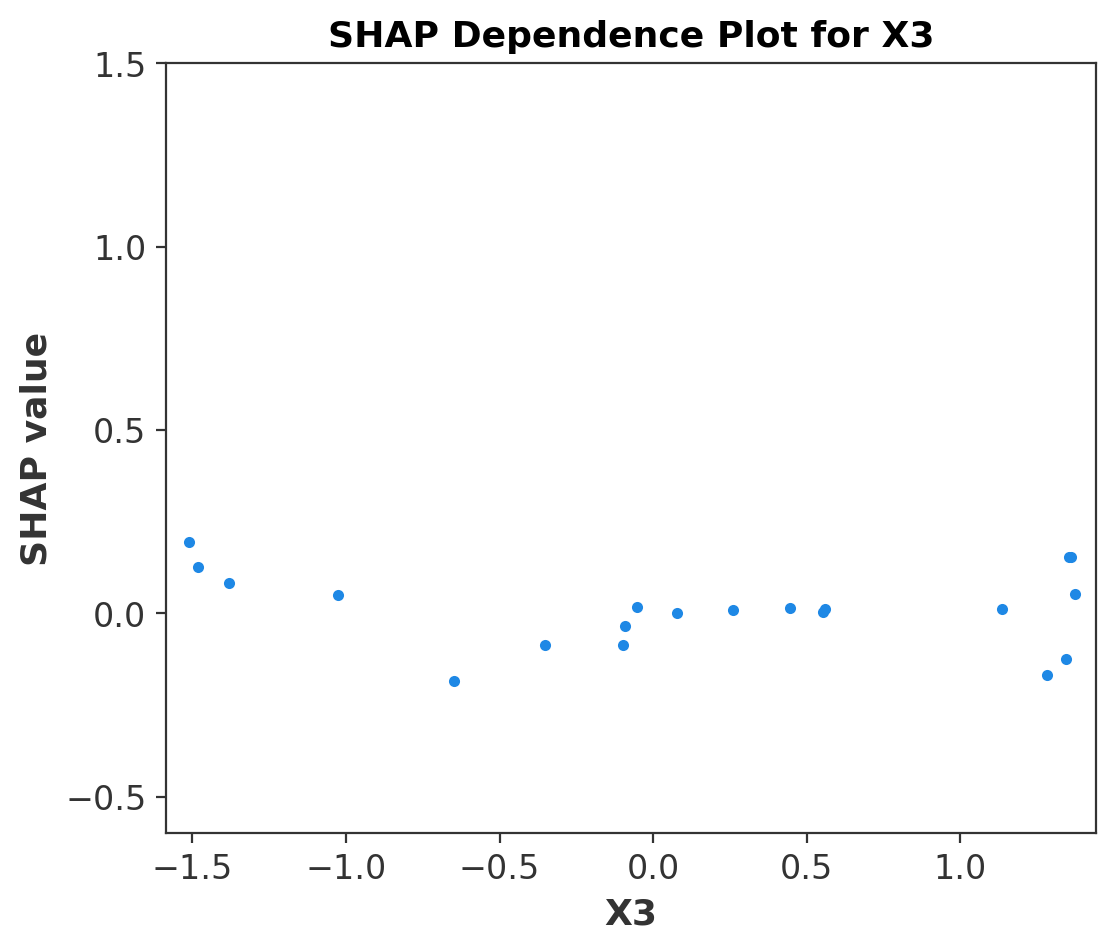

<Figure size 1600x1600 with 0 Axes>

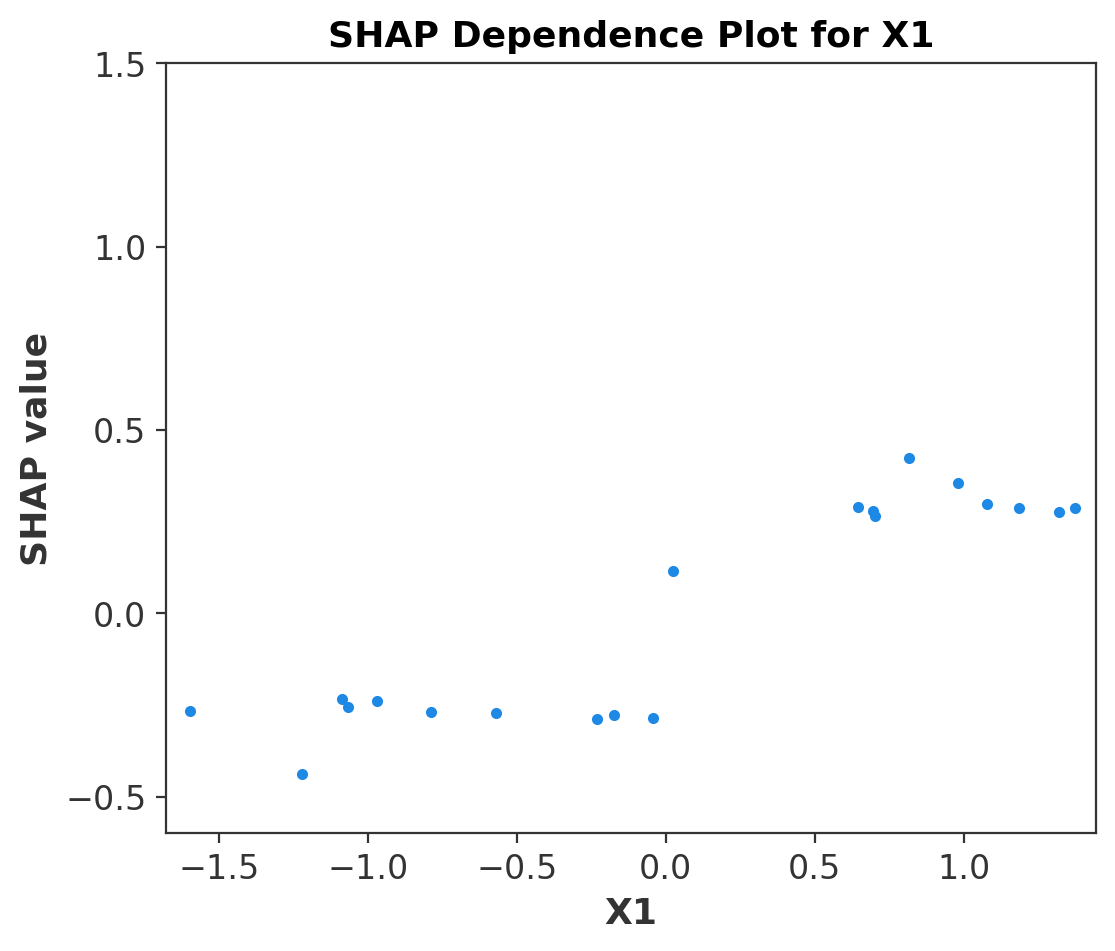

<Figure size 1600x1600 with 0 Axes>

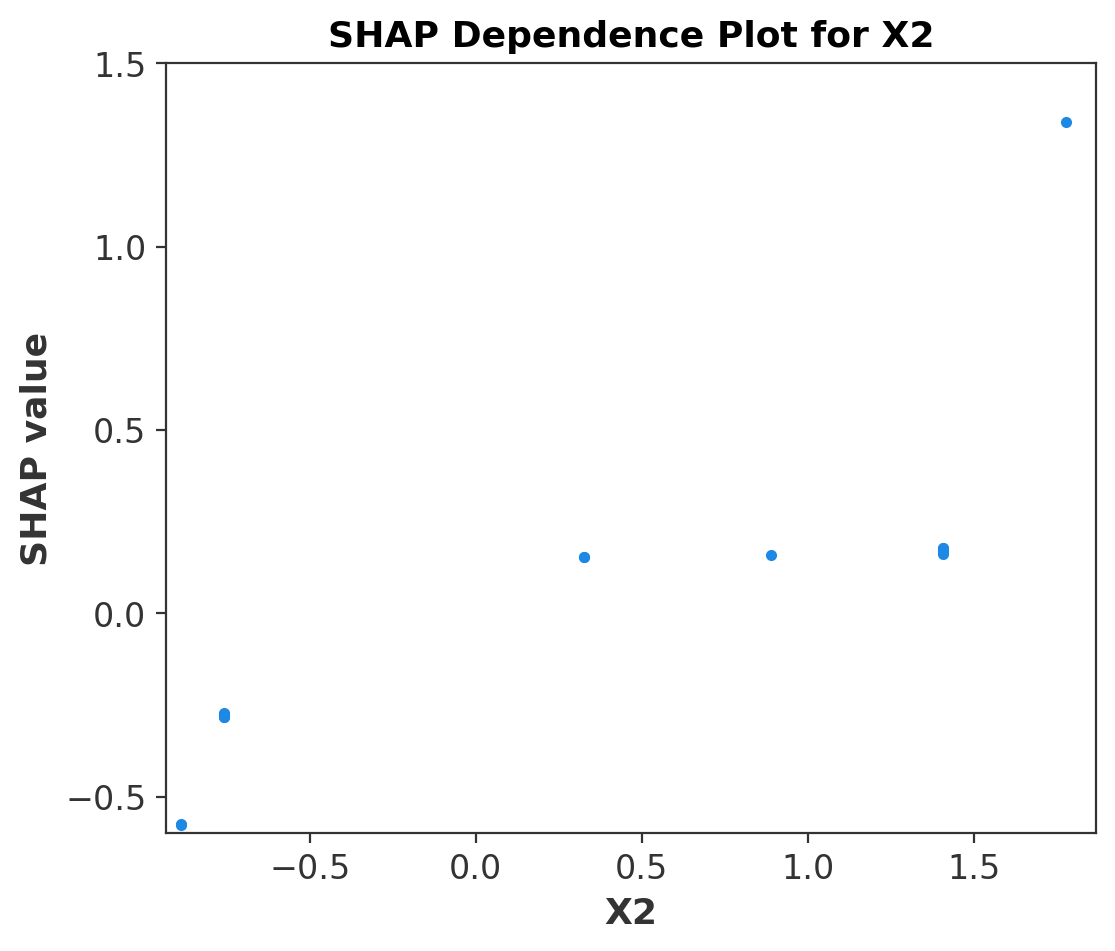

In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume model, X_train, and X_test are already defined

# SHAP Analysis
explainer = shap.Explainer(best_model, X_train)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Create Pandas DataFrames with feature names for X_train and X_test
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate SHAP values and data
shap_values_combined = np.concatenate((shap_values_train.values, shap_values_test.values), axis=0)
X_combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Calculate mean absolute SHAP values to identify top 3 features
mean_abs_shap_values = np.mean(np.abs(shap_values_combined), axis=0)
top_3_indices = np.argsort(mean_abs_shap_values)[-3:]
top_3_features = X_combined_df.columns[top_3_indices]

# Filter SHAP values and data for top 3 features
shap_values_combined_top3 = shap_values_combined[:, top_3_indices]
X_combined_df_top3 = X_combined_df.iloc[:, top_3_indices]

# Set up Matplotlib font properties
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.dpi'] = 200

# Generate SHAP dependence plots for each of the top 3 features with square plots
for feature in top_3_features:
    plt.figure(figsize=(8, 8))  # Set square figure size (8x8 inches)

    # Create the SHAP dependence plot
    shap.dependence_plot(
        feature,
        shap_values_combined,
        X_combined_df,
        interaction_index=None,
        show=False
    )

    # Get current axes object
    ax = plt.gca()

    # Customize the spines to add axes on top and right
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Set the aspect ratio to be square
    ax.set_aspect('auto')

    # Set y-ticks to range from -0.5 to 1.5
    plt.yticks(np.arange(-1.0, 1.6, 0.5), fontsize=12, fontweight='normal')

    # Set x-ticks and remove bold font weight
    plt.xticks(fontsize=12, fontweight='normal')

    plt.title(f"SHAP Dependence Plot for {feature}", fontsize=13, fontweight='bold')
    plt.xlabel(feature, fontsize=13, fontweight='bold')
    plt.ylabel("SHAP value", fontsize=13, fontweight='bold')

    # Adjust x and y limits to ensure proper spacing
    plt.xlim(X_combined_df[feature].min() - 0.05 * np.abs(X_combined_df[feature].min()),
             X_combined_df[feature].max() + 0.05 * np.abs(X_combined_df[feature].max()))
    plt.ylim(-0.6, 1.5)

    plt.show()


In [ ]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assume model, X_train, and X_test are already defined

# SHAP Analysis
explainer = shap.Explainer(model, X_train)
shap_values_train = explainer(X_train)
shap_values_test = explainer(X_test)

# Create Pandas DataFrames with feature names for X_train and X_test
X_train_df = pd.DataFrame(X_train, columns=X_train.columns)
X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

# Concatenate SHAP values and data
shap_values_combined = np.concatenate((shap_values_train.values, shap_values_test.values), axis=0)
X_combined_df = pd.concat([X_train_df, X_test_df], axis=0)

# Calculate mean absolute SHAP values to identify top 3 features
mean_abs_shap_values = np.mean(np.abs(shap_values_combined), axis=0)
top_3_indices = np.argsort(mean_abs_shap_values)[-3:]
top_3_features = X_combined_df.columns[top_3_indices]

# Filter SHAP values and data for top 3 features
shap_values_combined_top3 = shap_values_combined[:, top_3_indices]
X_combined_df_top3 = X_combined_df.iloc[:, top_3_indices]

# Set up Matplotlib font properties
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.dpi'] = 800

# Generate SHAP dependence plots for each of the top 3 features with square plots
for feature in top_3_features:
    plt.figure(figsize=(8, 8))  # Set square figure size (8x8 inches)

    # Create the SHAP dependence plot
    shap.dependence_plot(
        feature,
        shap_values_combined,
        X_combined_df,
        interaction_index=None,
        show=False
    )

    # Get current axes object
    ax = plt.gca()

    # Customize the spines to add axes on top and right
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

    # Set the aspect ratio to be square
    ax.set_aspect('auto')

    # Customize x-ticks and limits based on the feature
    if feature == 'Molecular Weight':
        plt.xticks(np.arange(0, 451, 50), fontsize=13, fontweight='normal')
        plt.xlim(135, 415)
    elif feature == 'Electron N':
        plt.xticks(np.arange(-0.72, -0.65, 0.02), fontsize=13, fontweight='normal')
        plt.xlim(-0.725, -0.655)
    else:
        plt.xticks(fontsize=13, fontweight='normal')
        plt.xlim(X_combined_df[feature].min() - 0.05 * np.abs(X_combined_df[feature].min()),
                 X_combined_df[feature].max() + 0.05 * np.abs(X_combined_df[feature].max()))

    # Set y-ticks to range from -0.5 to 1.5
    plt.yticks(np.arange(-1.0, 1.6, 0.5), fontsize=12, fontweight='normal')

    plt.title(f"SHAP Dependence Plot for {feature}", fontsize=13, fontweight='bold')
    plt.xlabel(feature, fontsize=14, fontweight='bold')
    plt.ylabel("SHAP value", fontsize=14, fontweight='bold')

    # Adjust y-limits to ensure proper spacing
    plt.ylim(-0.6, 1.5)

    plt.show()


NameError: name 'model' is not defined